In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from sklearn.metrics import accuracy_score
from keras import backend as K

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Данные:
Будем работать с датасетом [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). 

In [207]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
del y_train, y_test

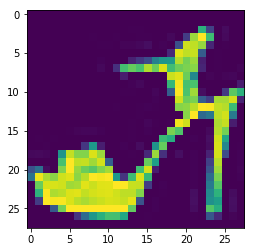

In [156]:
plt.imshow(X_train[9].reshape([28,28]))

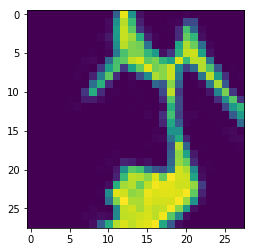

In [251]:
plt.imshow(transform.rotate(X_train[9].reshape([28,28]), 45))

### Задание.
Ваша задача - определить, при каком минимальном угле поворота нейронная сеть фиксированной архитектуры перестает различать обычное и повертнутое изображение. Говоря формально, решаем задачу классификации, исходные изображения принадлежат классу `0`, повернутые - классу `1`. Оцените точность классификации по метрике `accuracy` и ее дисперсию в зависимости от угла поворота изображения и отобразите данную зависимость на графике.

Функция `rotate_dataset` поворачивает поданный датасет на заданный угол. Функция `reset_weights` сбрасывает параметры модели.

*Обращаем ваше внимание, что для качественной оценки данных зависимостей эксперименты для каждого размера выборки стоит повторять многократно на различных случайных подвыборках.*

In [5]:
base_indices = np.random.choice(np.arange(X_train.shape[0]), size=500, replace=False)

# Важно!
В коде примера base_dataset - матрицы целых числел от 0 до 255

transform.rotate возвращает матрицу вещественных чисел от 0 до 1

imshow рисует их одинаково, но нейросеть без труда различает матрцы, ненулевые элементы которых в среднем различаются на 3 порядка, поэтому в исходном датасете нужно перейти к представлению изображений в вещественных числах

In [172]:
#base_dataset = X_train[base_indices].reshape([-1, 28,28]) - wrong!
base_dataset = X_train[base_indices].reshape([-1, 28,28]) / 255

In [173]:
def rotate_dataset(dataset, angle):
    return np.array(list(map(lambda x: transform.rotate(x, angle), dataset)))

In [174]:
def get_X_and_y(base_dataset, angle):
    rotated_datased = rotate_dataset(base_dataset, angle)
    whole_dataset = np.vstack((base_dataset, rotated_datased)).reshape(-1, 784)
    shuffled_indices = np.arange(len(whole_dataset))
    np.random.shuffle(shuffled_indices)
    
    _labels = np.zeros(2*base_dataset.shape[0], dtype=bool)
    _labels[base_dataset.shape[0]:] = True
    _labels = _labels[:, None]
    
    whole_labels = np.array(np.hstack((_labels, ~_labels)), dtype=int)
    
    whole_dataset = whole_dataset[shuffled_indices]
    whole_labels = whole_labels[shuffled_indices]
    
    return whole_dataset, whole_labels


In [178]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
    return

In [ ]:
batch_size = 128
n_epochs = 40

def create_nn():
    
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer([784]))
    model.add(keras.layers.Dense(64))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(2))
    model.add(keras.layers.Activation('softmax'))
    model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [244]:
X_test_whole, y_test_whole = get_X_and_y(X_test[np.random.choice(10000, 1000)], angle)
def train_and_estimate_accuracy(angle, debug=False):
    model = create_nn()
    X, y = get_X_and_y(base_dataset, angle)
    model.fit(X, y,
              batch_size=batch_size,
              epochs=n_epochs,
              verbose=0)
    
    #print("X shape: ", X.shape)

    #y_test_predicted_whole = model.predict_classes(X_test_whole)
    
    whole_score = accuracy_score(y_test_whole[:, 1], model.predict_classes(X_test_whole) )
    ##train_score = accuracy_score(y[:, 1], model.predict_classes(X.reshape([-1, 784])))
    if debug:
        print (whole_score, train_score)
        return (model, X, y)
    else:
        return whole_score

Построим график зависимости accuracy от угла поворота изображений.
При повороте на 0 и 360 градусов, как и ожидалось, accuracy около 0.5, 
кроме этого плохо классифицируятся изображения, повёрнутные на 180 и (почему-то) на $\approx$ 75 градусов

CPU times: user 4min 1s, sys: 4.1 s, total: 4min 5s
Wall time: 3min 26s


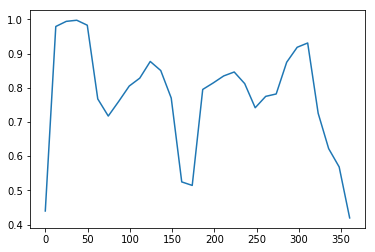

In [223]:
%%time
angles = np.linspace(0, 360, 30)
acc_wide_range = [train_and_estimate_accuracy(angle) for angle in angles]
plt.plot(angles, acc_wide_range)

Построим более подробный график области около 0 градусов

In [265]:
%%time
angles = np.linspace(0, 20, 10)
n_repetitions = 5
results = [[train_and_estimate_accuracy(angle) for _ in range(n_repetitions)] for angle in angles]

CPU times: user 15min 15s, sys: 7.65 s, total: 15min 22s
Wall time: 14min 22s


In [280]:
acc_around_zero = np.mean(results, axis=1)
std = np.std(results, axis=1)

Text(0,0.5,'Accuracy')

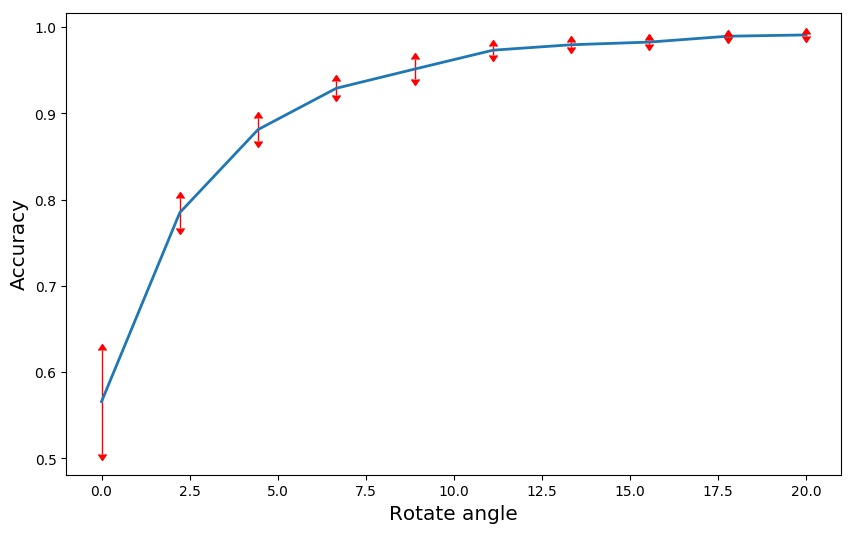

In [317]:
plt.figure(figsize = (10,6))
plt.plot(angles, acc_around_zero, linewidth=2)
plt.errorbar(angles, acc_around_zero, std, fmt='none', color="red", elinewidth=1, uplims=True, lolims=True)
plt.xlabel("Rotate angle", {"fontsize":"x-large"})
plt.ylabel("Accuracy", {"fontsize":"x-large"})

Резкое уменьшение accuracy начинается при уменьшении угла поворота примерно до 5 градусов,
при примерно 2 градусах модель становится непригодной для распознавания